In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6



In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


data = pd.read_csv('data/LB.csv',  
                   index_col='date',
                   date_parser=dateparse)
data.head()

D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,open,high,low,close,adj close,volume
date,,,,,,
2019-01-02,25.090000,26.750000,24.980000,26.309999,24.518690,5401700
2019-01-03,26.160000,27.059999,25.900000,26.459999,24.658476,5116900
2019-01-04,26.799999,28.250000,26.799999,27.709999,25.823374,5839200
2019-01-07,27.639999,29.690001,27.290001,28.870001,26.904396,5465100
2019-01-08,29.080000,29.100000,27.200001,28.200001,26.280012,5330700


In [3]:
# расчитать
data['prev_day_diff'] = data['adj close']-data['close'].shift(1)
# sma - долше период замедленей реакция (10 - короткая, 50 - среднее, 200 - длинный)
data['50_day_moving_avg'] = data['adj close'].rolling(50).mean()
data['10_day_volatility'] = data['adj close'].rolling(10).std(ddof=0)
data.dropna(inplace = True)
data.head()

,open,high,low,close,adj close,volume,prev_day_diff,50_day_moving_avg,10_day_volatility
date,,,,,,,,,
2019-03-14,27.000000,27.000000,26.059999,26.230000,24.713942,4567500,-2.366058,25.348236,0.438564
2019-03-15,26.360001,26.750000,26.000000,26.580000,25.043713,8301900,-1.186287,25.358737,0.331189
2019-03-18,26.719999,27.520000,26.580000,27.450001,25.863428,3349100,-0.716572,25.382836,0.423085
2019-03-19,27.520000,28.469999,27.379999,28.180000,26.551235,4995700,-0.898766,25.397393,0.622681
2019-03-20,27.950001,28.100000,27.410000,27.549999,25.957647,4239000,-2.222353,25.378458,0.667438


# Обзор Time Series

In [4]:
# разбор time series
adj = data['adj close']
adj.head(10)

date
2019-03-14    24.713942
2019-03-15    25.043713
2019-03-18    25.863428
2019-03-19    26.551235
2019-03-20    25.957647
2019-03-21    26.277994
2019-03-22    25.128511
2019-03-25    25.788052
2019-03-26    26.315683
2019-03-27    26.815050
Name: adj close, dtype: float64

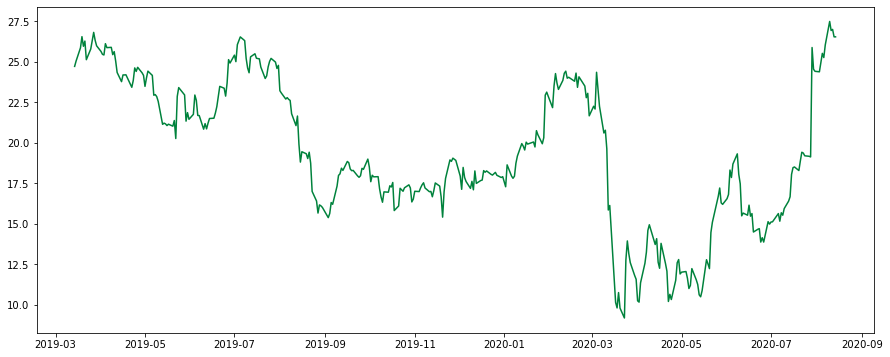

In [5]:
plt.plot(adj, color='#00823c')

In [6]:
from statsmodels.tsa.stattools import adfuller

def stationarity(timeseries):
    """
        Расчет неизменности во времени(stationarity)
        То есть, всегда есть такое же кол-во в любом варианте окна.
    """
    
    #Определяем плавующие окна (средней и отклонение)
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(50).std(ddof=0)

    #Визуализируем:
    orig = plt.plot(timeseries, color='#00823c',label='Original')
    mean = plt.plot(rolmean, color='#c00000', label='Mean')
    std = plt.plot(rolstd, color='#6db9ff', label = 'Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & STD')
    plt.show(block=False)
    
    #Тест Дикки-Фуллера
    print('Результат теста Дикки-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['open','high','Изменяемость на 10 дней', 'Плавающее среднее на 50 дней'])
    for key, value in dftest[4].items():
        dfoutput['Критическое значение (%s)'%key] = value
    print(dfoutput)

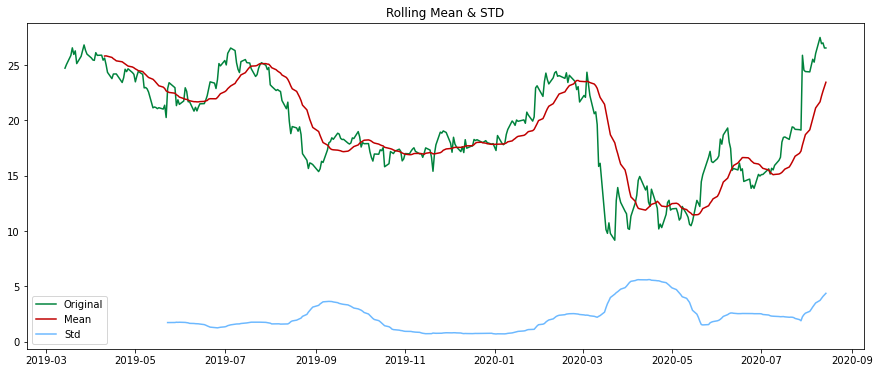

Результат теста Дикки-Фуллера:
open                             -1.718380
high                              0.421668
Изменяемость на 10 дней           0.000000
Плавающее среднее на 50 дней    359.000000
Критическое значение (1%)        -3.448697
Критическое значение (5%)        -2.869625
Критическое значение (10%)       -2.571077
dtype: float64


In [7]:
stationarity(adj)

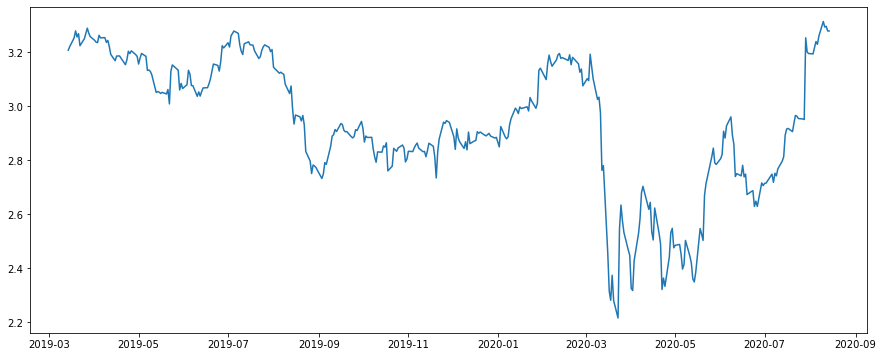

In [8]:
# логорифмирование
adj_log = np.log(adj)
plt.plot(adj_log)

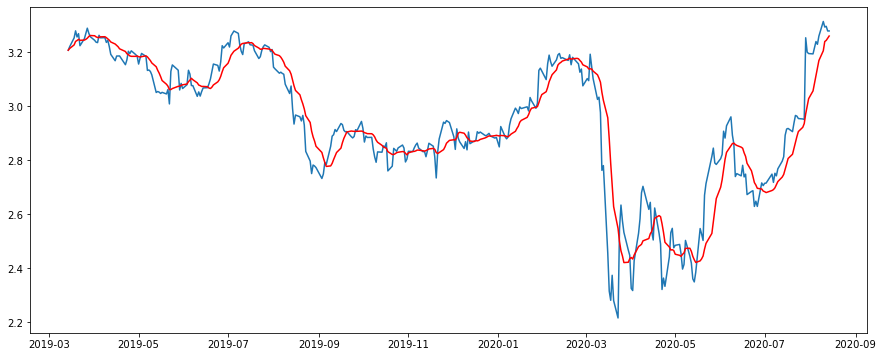

In [9]:
# сглаживание (виз для тренда)
moving_avg = adj_log.rolling(window = 10, min_periods=1).mean()
plt.plot(adj_log)
plt.plot(moving_avg, color='red')

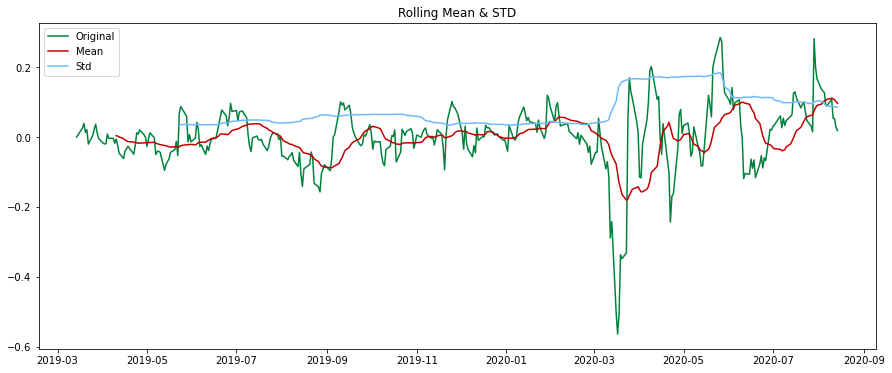

Результат теста Дикки-Фуллера:
open                             -4.971642
high                              0.000025
Изменяемость на 10 дней           6.000000
Плавающее среднее на 50 дней    353.000000
Критическое значение (1%)        -3.449011
Критическое значение (5%)        -2.869763
Критическое значение (10%)       -2.571151
dtype: float64


In [10]:
# расчет разницы в данных
adj_log_moving_avg_diff = adj_log - moving_avg
adj_log_moving_avg_diff.dropna(inplace=True)
stationarity(adj_log_moving_avg_diff)

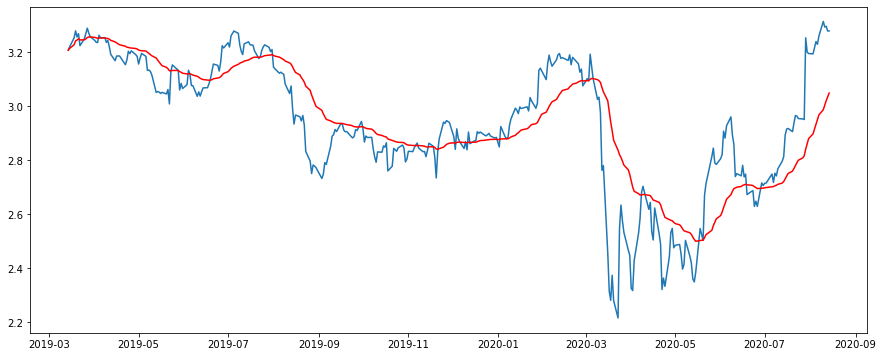

In [11]:
expwighted_avg = adj_log.ewm(halflife = 12).mean()
plt.plot(adj_log)
plt.plot(expwighted_avg, color='red')

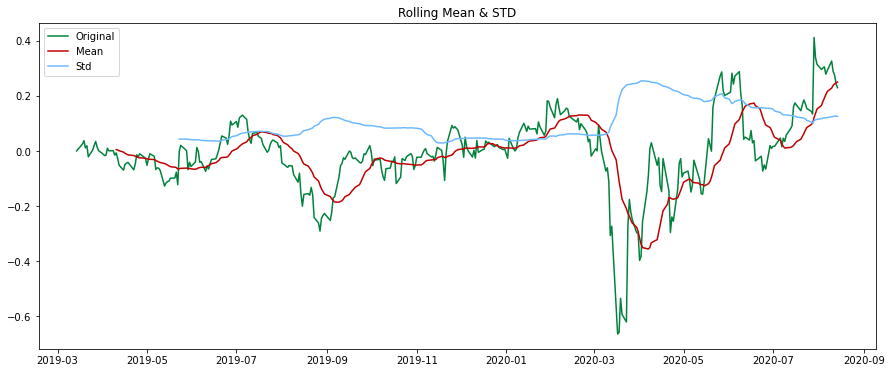

Результат теста Дикки-Фуллера:
open                             -3.124460
high                              0.024795
Изменяемость на 10 дней           0.000000
Плавающее среднее на 50 дней    359.000000
Критическое значение (1%)        -3.448697
Критическое значение (5%)        -2.869625
Критическое значение (10%)       -2.571077
dtype: float64


In [12]:
adj_log_ewma_diff = adj_log - expwighted_avg
stationarity(adj_log_ewma_diff)

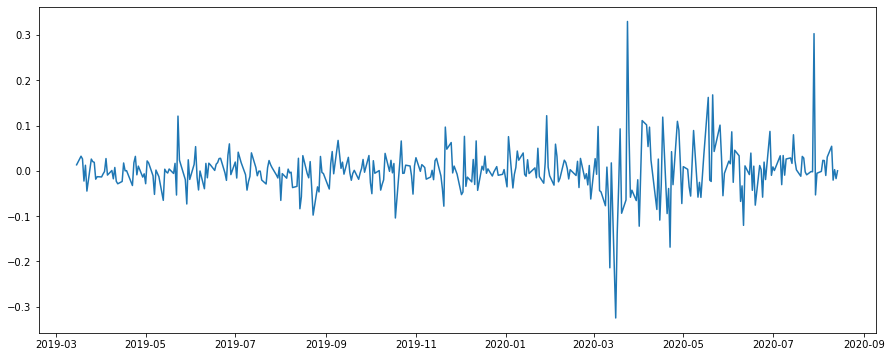

In [13]:
# делаем обзор разниц
adj_log_diff = adj_log - adj_log.shift(1)
plt.plot(adj_log_diff)

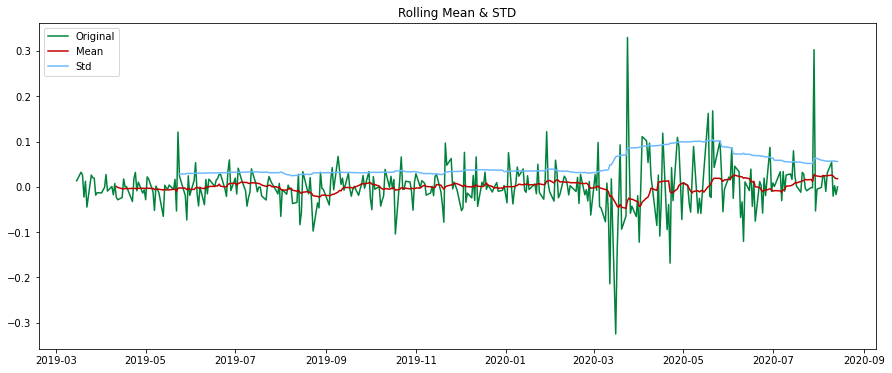

Результат теста Дикки-Фуллера:
open                           -1.784321e+01
high                            3.100266e-30
Изменяемость на 10 дней         0.000000e+00
Плавающее среднее на 50 дней    3.580000e+02
Критическое значение (1%)      -3.448749e+00
Критическое значение (5%)      -2.869647e+00
Критическое значение (10%)     -2.571089e+00
dtype: float64


In [14]:
adj_log_diff.dropna(inplace=True)
stationarity(adj_log_diff)

# Декомпозиция

D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


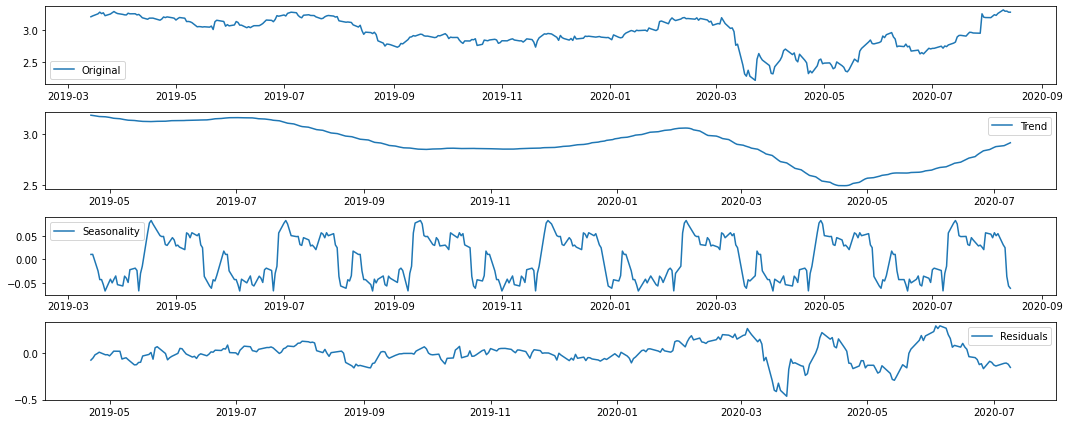

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(adj_log, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(adj_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

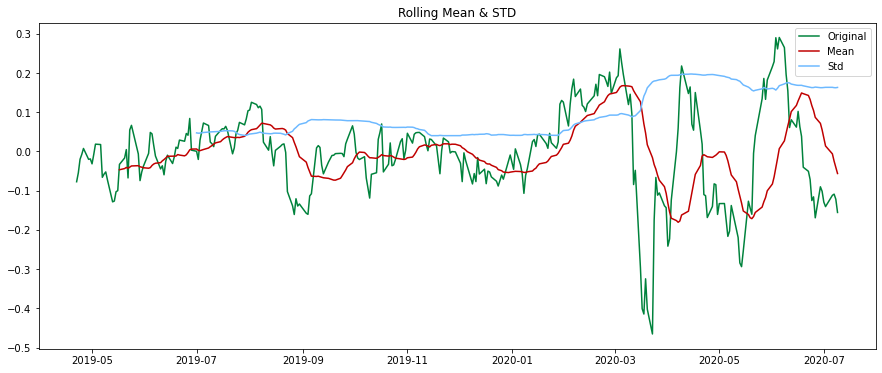

Результат теста Дикки-Фуллера:
open                             -4.526175
high                              0.000176
Изменяемость на 10 дней           7.000000
Плавающее среднее на 50 дней    300.000000
Критическое значение (1%)        -3.452337
Критическое значение (5%)        -2.871223
Критическое значение (10%)       -2.571929
dtype: float64


In [16]:
adj_log_decompose = residual
adj_log_decompose.dropna(inplace=True)
stationarity(adj_log_decompose)

# Предикт

In [17]:
from statsmodels.tsa.arima_model import ARIMA
#ACF / PACF
from statsmodels.tsa.stattools import acf, pacf  

D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


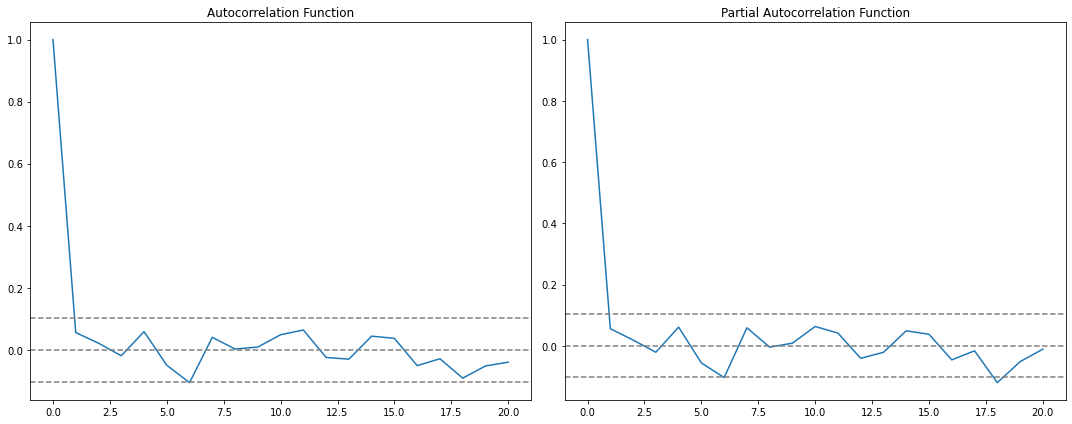

In [18]:
lag_acf = acf(adj_log_diff, nlags=20)
lag_pacf = pacf(adj_log_diff, nlags=20, method='ols')

#ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.9976')

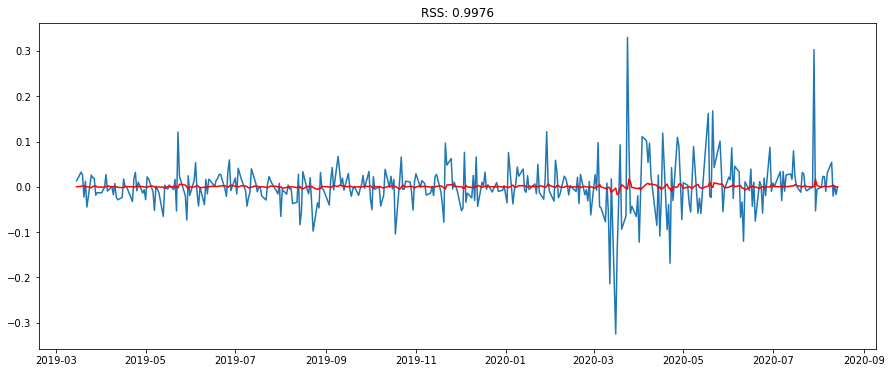

In [19]:
#MA model:
model = ARIMA(adj_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-adj_log_diff)**2))

D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.9976')

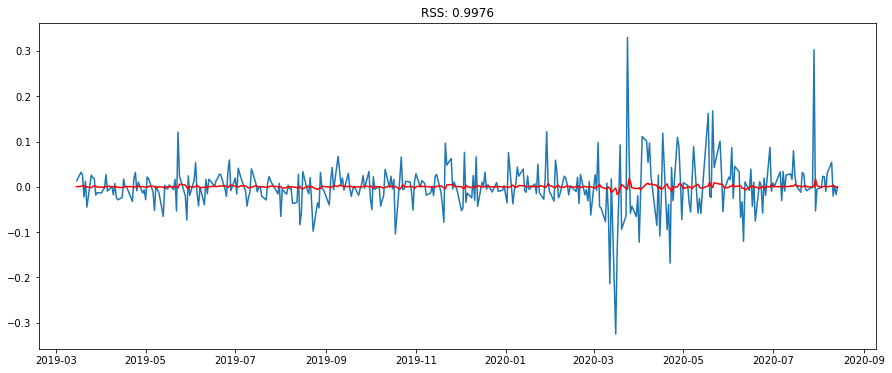

In [20]:
model = ARIMA(adj_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-adj_log_diff)**2))

D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\installprogramm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS (Root Squared Sum): 0.9821')

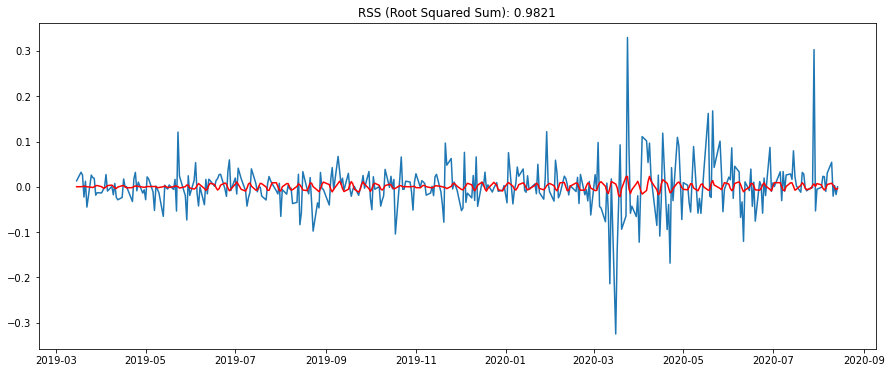

In [21]:
model = ARIMA(adj_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS (Root Squared Sum): %.4f'% sum((results_ARIMA.fittedvalues-adj_log_diff)**2))

# Конвертация в оригинал 

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(adj_log[0], index=adj_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

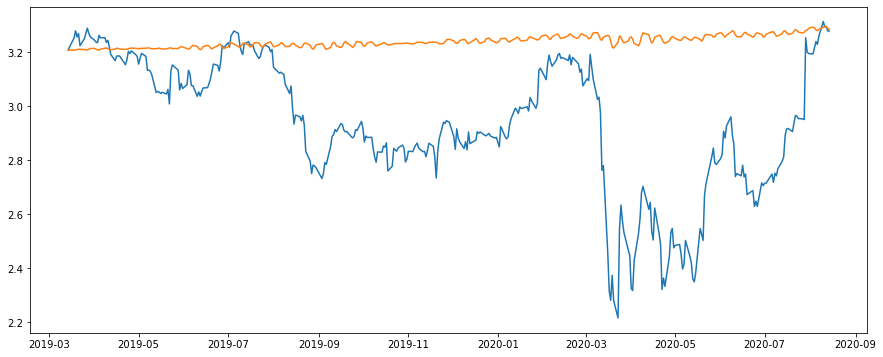

In [23]:
plt.plot(adj_log)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 7.6974')

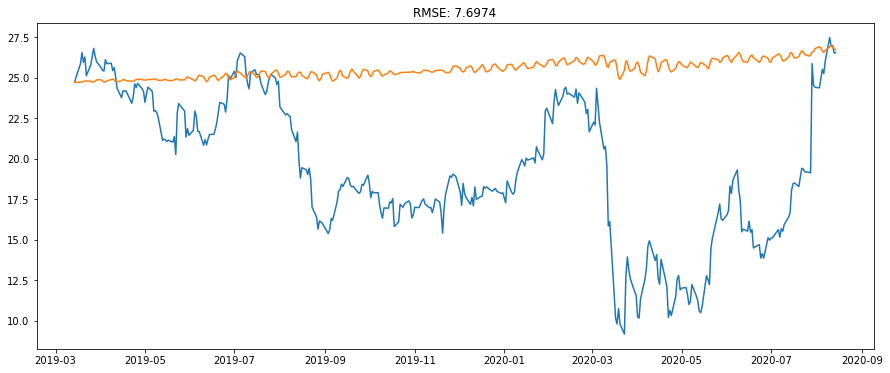

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(adj)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-adj)**2)/len(adj)))

# Делаем ML алгоритмами

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [25]:
data.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'prev_day_diff',
       '50_day_moving_avg', '10_day_volatility'],
      dtype='object')

In [32]:
df_x = data.reset_index()[['open', 'high', 'low', 'close', 'volume', 'prev_day_diff', '50_day_moving_avg', '10_day_volatility']]
df_y = data.reset_index()['adj close']

# Regression

In [38]:
reg = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2,random_state=4)
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
y_predicted = reg.predict(x_test)
print(y_predicted[:5])

[23.52422022 19.0840728  17.08598602 25.65134238 15.86739899]


45    2019-05-17
303   2020-05-27
100   2019-08-06
188   2019-12-10
33    2019-05-01
         ...    
306   2020-06-01
87    2019-07-18
197   2019-12-23
174   2019-11-19
122   2019-09-06
Name: date, Length: 288, dtype: datetime64[ns]

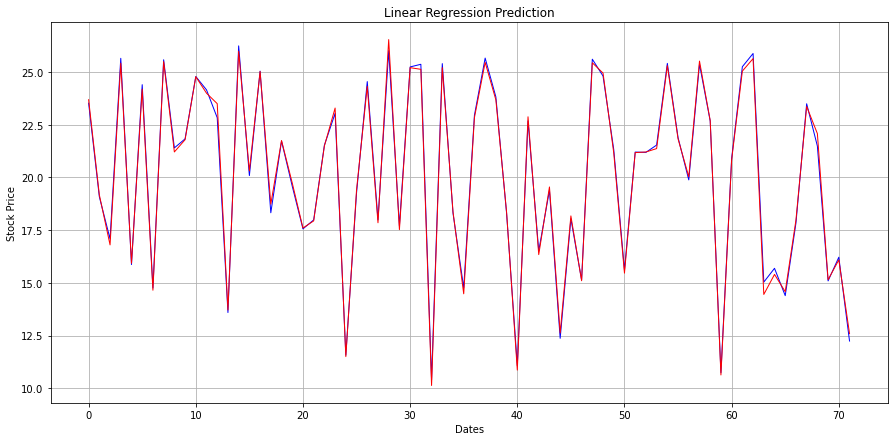

In [52]:
plt.figure(figsize=(15,7))
plt.plot(y_predicted, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

plt.title('Linear Regression Prediction')
plt.ylabel('Stock Price')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

In [54]:
errors = abs (y_predicted - y_test.values)
print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error:  0.17 degrees.


In [55]:
# MAPE
mape = 100 * (errors/y_test.values)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  99.09 %.


# SVR

In [56]:
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf.fit(x_train, y_train) 
predictions = clf.predict(x_test)

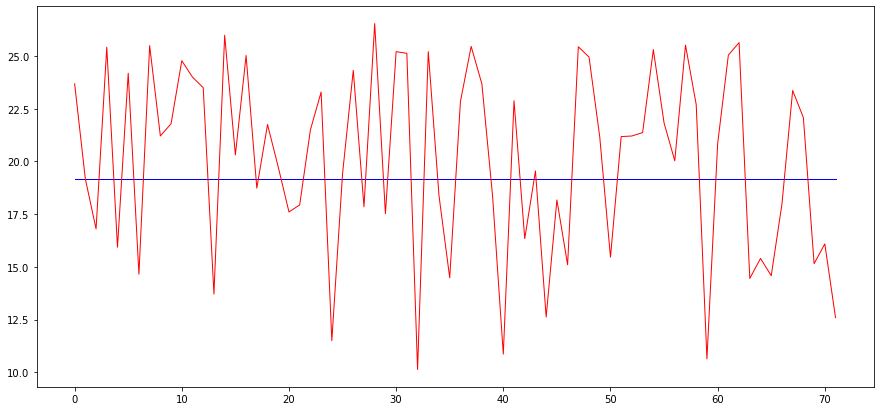

In [59]:
plt.figure(figsize=(15,7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [61]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  78.63 %.


# Decision Tree Regression

In [63]:
regressor = DecisionTreeRegressor(max_depth=10)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

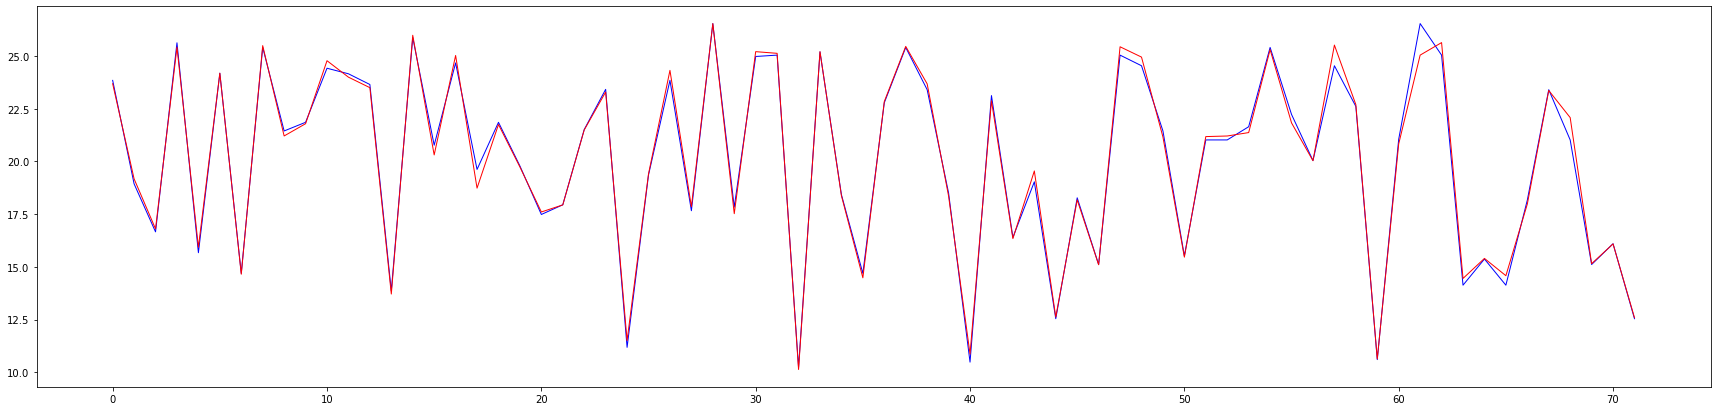

In [64]:
plt.figure(figsize=(30,7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [65]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  98.87 %.


# Regression Forest

In [66]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

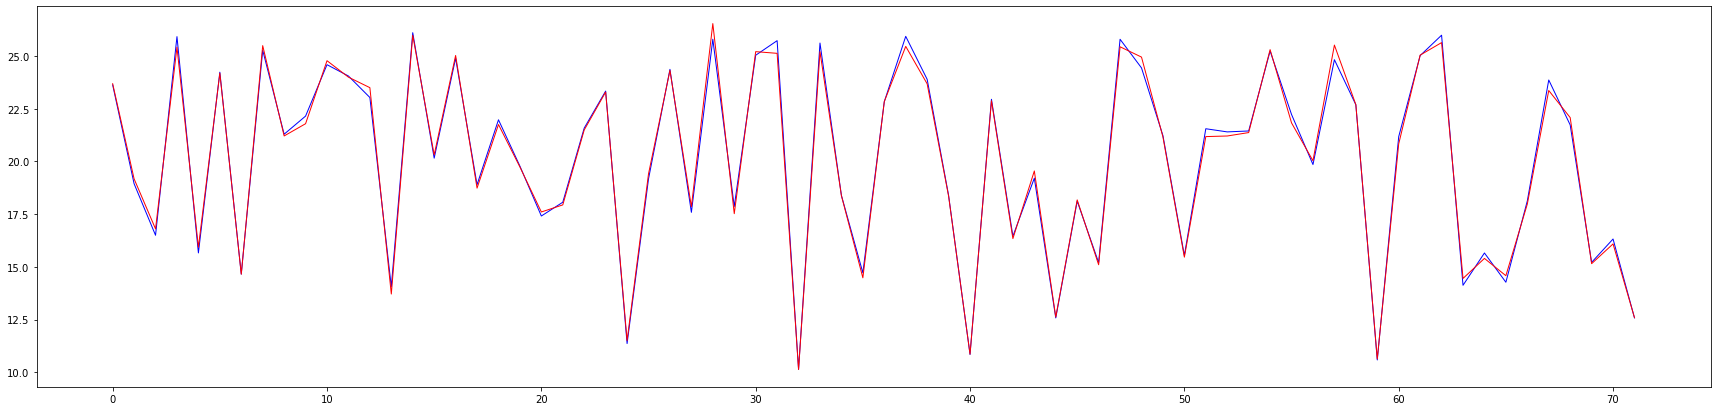

In [70]:
plt.figure(figsize=(30, 7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [71]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  98.98 %.
